Author: Tim Gorman </br>

# Imports

In [10]:
import boto3
import pandas as pd
import json
import math
import matplotlib.pyplot as plt

# Load Data

In [3]:
port_df = pd.read_json('/root/starbucks_offer_response_model/data/portfolio.json', orient = 'records', lines = True)
prof_df = pd.read_json('/root/starbucks_offer_response_model/data/profile.json', orient = 'records', lines = True)
trans_df = pd.read_json('/root/starbucks_offer_response_model/data/transcript.json', orient = 'records', lines = True)

# Exploratory Data Analysis

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Renaming Columns

In [4]:
port_col_dict = {"id":"offer_id"}
prof_col_dict = {"id": "customer_id"}
trans_col_dict = {"person":"customer_id"}

In [5]:
port_df = port_df.rename(columns = port_col_dict)
prof_df = prof_df.rename(columns = prof_col_dict)
trans_df = trans_df.rename(columns = trans_col_dict)

## Portfolio

In [6]:
port_df

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


Above is a list of the 10 offers that are available in the app and the relevant features. ID in this data frame is actually offer id, as opposed to the custoemr id in profile

In [7]:
port_df = pd.concat([port_df,pd.get_dummies(port_df['offer_type'].copy())])
port_df.head()

,reward,channels,difficulty,duration,offer_type,offer_id,bogo,discount,informational
0,10.0,"[email, mobile, social]",10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN
1,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
2,0.0,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
3,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
4,5.0,"[web, email]",20.0,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN


## Profile

In [6]:
len(prof_df)

17000

In [7]:
prof_df.head()

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
prof_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   customer_id       17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [73]:
prof_df['gender'].fillna('missing').value_counts()

M          8484
F          6129
missing    2175
O           212
Name: gender, dtype: int64

In [11]:
prof_df.nunique()

gender                  3
age                    85
customer_id         17000
became_member_on     1716
income                 91
dtype: int64

Customer Id can be used as a key becuase it is a unique, non-null identifier for profiles.

In [9]:
prof_df.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


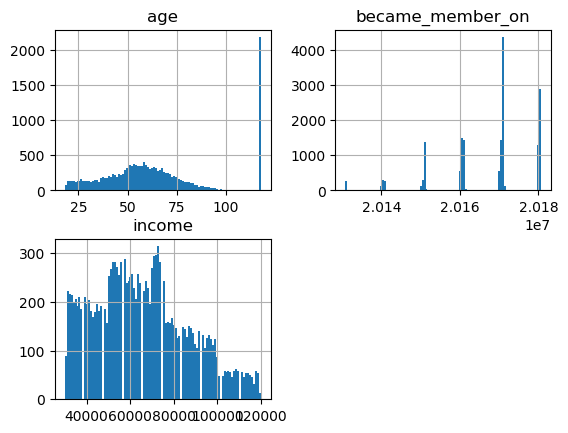

In [23]:
prof_df.hist(bins = 100)
plt.show()

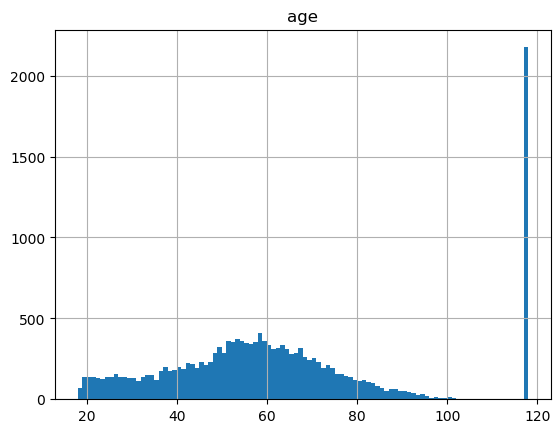

In [17]:
prof_df.hist(column = 'age', bins = 100)
plt.show()

In [19]:
prof_df['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
101       5
99        5
Name: age, Length: 85, dtype: int64

In [25]:
prof_df[prof_df['age']!= 118]['age'].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [76]:
pd.cut(prof_df['age'], bins = [17,42, 55, 66, 118], labels=['age1','age2', 'age3', 'age4'])

0        age4
1        age2
2        age4
3        age4
4        age4
         ... 
16995    age2
16996    age3
16997    age2
16998    age4
16999    age3
Name: age, Length: 17000, dtype: category
Categories (4, object): ['age1' < 'age2' < 'age3' < 'age4']

There is a large portion of the age group that is at 118 years old. This obviously seems to be untrue or some sort of error. So I'll calculate the quartiles excluding that age and then bin the ages based on those resulting quartile values. When I generate features, I'll use these bins to remove ordinality between these clearly disparate age groups.

From the histogram above, it looks like income can be binned into 4 groups

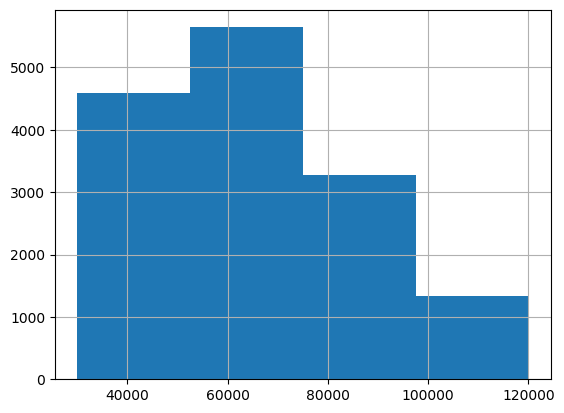

(52500.0, 75000.0]     5887
(29910.0, 52500.0]     4583
(75000.0, 97500.0]     3027
(97500.0, 120000.0]    1328
Name: income, dtype: int64

In [61]:
prof_df['income'].hist(bins = 4)
plt.show()
pd.cut(prof_df['income'], bins = 4).value_counts()

I'll use these to bin the data as well

In [52]:
prof_df['became_member_on'].describe()

count    1.700000e+04
mean     2.016703e+07
std      1.167750e+04
min      2.013073e+07
25%      2.016053e+07
50%      2.017080e+07
75%      2.017123e+07
max      2.018073e+07
Name: became_member_on, dtype: float64

In [69]:
(2018-pd.to_datetime(prof_df['became_member_on'].astype('str'), format = '%Y%m%d').dt.year.astype('int')).value_counts()

1    6469
0    4198
2    3526
3    1830
4     691
5     286
Name: became_member_on, dtype: int64

I will use the above column to make a feature that is "years_as_member". I won't bin this one becuase I sort of expect there to be some meaningful relationship to how long one is a member that is roughly correlated with how well they will respond to offers.

## Transcript

In [12]:
len(trans_df)

306534

In [13]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  306534 non-null  object
 1   event        306534 non-null  object
 2   value        306534 non-null  object
 3   time         306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [14]:
trans_df.head(5)

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [15]:
trans_df.tail()

,customer_id,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [16]:
(trans_df['time'].max() - trans_df['time'].min())/24

29.75

The above tells us that the test ran over a period of 30 days. This is a fairly small window so I think it is reasonable to say that if a customer responds to an offer even once then the offer was successful. However, some offers are completed without viewing. In those cases we wouldn't say that the customer responded to the offer. One way to handle this would be to count how many offers were recieved and if 

In [17]:
trans_df['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

There are 5 kinds of events shown above: transaction, offer recieved, offer viewed, offer completed.

Since this is a response model, I will reduce the model input population to profiles that recieved the offer in question.

Target: whether or not offer was completed.

I can make a sub mmodel for each kind of offer: informational, bogo, and discount.

So I will have three models that will 

### Diving into one person that completed an offer

In [18]:
trans_df[trans_df['event']== 'offer completed']

,customer_id,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0
...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714


In [19]:
trans_df[trans_df['customer_id']== '9fa9ae8f57894cc9a3b8a9bbe0fc1b2f']

,customer_id,event,value,time
36,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
27850,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 21.55},42
44327,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 32.87},114
51350,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 19.99},156
65854,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 20.97},168
81403,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 31.09},204
110866,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},336


# Feature Generation

### port_df

In [20]:
port_df

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [21]:
from sklearn.preprocessing import MultiLabelBinarizer

In [22]:
port_df

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [23]:
mlb = MultiLabelBinarizer()
port_df = port_df.join(pd.DataFrame(mlb.fit_transform(port_df.pop('channels')),
                          columns=mlb.classes_,
                          index=port_df.index))

In [24]:
port_df

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


### trans_df

In [67]:
trans_df['offer_id'] = None
trans_df['amount'] = None
trans_df['reward'] = None

In [31]:
trans_df

,customer_id,event,value,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,None,None
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,None,None
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,None,None
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,None,None
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,None,None
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,None,None
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,None,None
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,None,None
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,None,None


In [30]:
value_df = trans_df['value'].apply(pd.Series)

In [31]:
value_df.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [32]:
value_df.tail()

,offer id,amount,offer_id,reward
306529,NaN,1.59,NaN,NaN
306530,NaN,9.53,NaN,NaN
306531,NaN,3.61,NaN,NaN
306532,NaN,3.53,NaN,NaN
306533,NaN,4.05,NaN,NaN


In [33]:
trans_df.loc[(trans_df['event'] == 'offer received'), 'offer_id'] = value_df['offer id']
trans_df.loc[(trans_df['event'] == 'offer viewed'), 'offer_id'] = value_df['offer id']
trans_df.loc[(trans_df['event'] == 'offer completed'), 'offer_id'] = value_df['offer_id']
trans_df.loc[(trans_df['event'] == 'offer completed'), 'reward'] = value_df['reward']
trans_df.loc[(trans_df['event']== 'transaction'), 'amount']  = value_df['amount']

In [43]:
trans_df = trans_df.drop(columns = ['value'])

In [44]:
trans_df[(trans_df['event'] == 'offer received')].head()

,customer_id,event,time,offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [45]:
trans_df[(trans_df['event'] == 'offer viewed')].head()

,customer_id,event,time,offer_id,reward,amount
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
12652,102e9454054946fda62242d2e176fdce,offer viewed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN


In [46]:
trans_df[(trans_df['event'] == 'offer completed')].head()

,customer_id,event,time,offer_id,reward,amount
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5,2.0,NaN
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,ae264e3637204a6fb9bb56bc8210ddfd,10.0,NaN
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,NaN


In [47]:
trans_df[(trans_df['event'] == 'transaction')].head()

,customer_id,event,time,offer_id,reward,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,NaN,NaN,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,NaN,NaN,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,NaN,NaN,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,NaN,NaN,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,NaN,NaN,18.97


# Merging the Data
After the merging step, I'd like a trans_df that has all info from the port_df and prof_df dataframes left joined ot it.

In [48]:
len(trans_df)

306534

In [49]:
detailed_trans_df = trans_df.merge(port_df, how = 'left', on = 'offer_id').merge(prof_df, how = 'left', on = 'customer_id').copy()

In [50]:
len(detailed_trans_df)

306534

In [51]:
detailed_trans_df.head()

,customer_id,event,time,offer_id,reward_x,amount,reward_y,difficulty,duration,offer_type,email,mobile,social,web,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,F,75,20170509,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,None,118,20170804,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,M,68,20180426,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,None,118,20170925,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,None,118,20171002,NaN
